In [113]:
from functions import *

In [114]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns

## Load data

### Choose inputs

In [115]:
W = 256
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'wt', 'masked']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}

for i,dir_p in enumerate(dir_paths):
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked'): #and rivers_count < max_rivers:
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked'):
            all_dir_paths['masked'].append(subdir)


all_dir_paths    

{'lst': ['../data/preprocessed/lst/LaVenoge_shapefile',
  '../data/preprocessed/lst/swissTLMboiron',
  '../data/preprocessed/lst/LaBroye_shapefile'],
 'ndvi': ['../data/preprocessed/ndvi/LaVenoge_shapefile',
  '../data/preprocessed/ndvi/swissTLMboiron',
  '../data/preprocessed/ndvi/LaBroye_shapefile'],
 'wt': ['../data/preprocessed/wt/LaVenoge_shapefile',
  '../data/preprocessed/wt/swissTLMboiron',
  '../data/preprocessed/wt/LaBroye_shapefile'],
 'masked': ['../data/preprocessed/lst/LaVenoge_shapefile/masked',
  '../data/preprocessed/lst/swissTLMboiron/masked',
  '../data/preprocessed/lst/LaBroye_shapefile/masked']}

In [116]:
total_data = {}
total_times = {}
filter_river = None
for k,v in all_dir_paths.items():
    if k == 'lst' or k == 'masked':
        list_rgb = [True]*len(v)
    else:
        list_rgb = [False]*len(v)
    
    if filter_river != None:
        v = [v[filter_river]]
    print('getting data for path',v) 
    data, times = load_data(v,W,list_rgb)
    
    #d = [item for sublist in data.values() for item in sublist]
    total_data[k] = np.concatenate(list(data.values()), axis=0)
    total_times[k] = times
    print(k,':' ,total_data[k].shape)
    

getting data for path ['../data/preprocessed/lst/LaVenoge_shapefile', '../data/preprocessed/lst/swissTLMboiron', '../data/preprocessed/lst/LaBroye_shapefile']


lst : (55, 256, 256, 3)
getting data for path ['../data/preprocessed/ndvi/LaVenoge_shapefile', '../data/preprocessed/ndvi/swissTLMboiron', '../data/preprocessed/ndvi/LaBroye_shapefile']
ndvi : (55, 256, 256)
getting data for path ['../data/preprocessed/wt/LaVenoge_shapefile', '../data/preprocessed/wt/swissTLMboiron', '../data/preprocessed/wt/LaBroye_shapefile']
wt : (55, 256, 256)
getting data for path ['../data/preprocessed/lst/LaVenoge_shapefile/masked', '../data/preprocessed/lst/swissTLMboiron/masked', '../data/preprocessed/lst/LaBroye_shapefile/masked']
masked : (55, 256, 256, 3)


In [117]:
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (55, 256, 256, 3) (55, 256, 256)
targets shape: (55, 256, 256)


In [118]:
'''for i in range(lst.shape[0]):
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))
    axes[0].set_title('lst')

    axes[1].imshow(ndvi[i])
    axes[1].set_title('ndvi')

    axes[2].imshow(data_targets[i])
    axes[2].set_title('wt')

    if total_times['lst'][0][i] != total_times['ndvi'][0][i] or total_times['lst'][0][i] != total_times['wt'][0][i] or total_times['ndvi'][0][i] != total_times['wt'][0][i]:
        print('Time mismatch')

    plt.suptitle(f"For time {total_times['lst'][0][0]}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()'''


'for i in range(lst.shape[0]):\n    fig, axes = plt.subplots(1,3, figsize=(10,5))\n    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))\n    axes[0].set_title(\'lst\')\n\n    axes[1].imshow(ndvi[i])\n    axes[1].set_title(\'ndvi\')\n\n    axes[2].imshow(data_targets[i])\n    axes[2].set_title(\'wt\')\n\n    if total_times[\'lst\'][0][i] != total_times[\'ndvi\'][0][i] or total_times[\'lst\'][0][i] != total_times[\'wt\'][0][i] or total_times[\'ndvi\'][0][i] != total_times[\'wt\'][0][i]:\n        print(\'Time mismatch\')\n\n    plt.suptitle(f"For time {total_times[\'lst\'][0][0]}", fontsize=16)\n    plt.tight_layout()\n    plt.subplots_adjust(top=0.9)\n    plt.show()'

In [119]:
inputs = 'lst' #'lst+ndvi' for ndvi inputs

Convert inputs to gray images

'''masked_gray_inputs = []
gray_inputs = []
for i in range(masked_inputs.shape[0]):
  masked_img_rgb = masked_inputs[i]
  masked_img_gray = np.dot(masked_img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  masked_gray_inputs.append(masked_img_gray)

  img_rgb = data_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  gray_inputs.append(img_gray)

masked_gray_inputs = np.array(masked_gray_inputs)
print(masked_gray_inputs.shape)

gray_inputs = np.array(gray_inputs)
print(gray_inputs.shape)'''

Split data

In [120]:
if inputs == 'lst':
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(lst, data_targets)
else:
  ndvi_expanded = np.expand_dims(ndvi, axis=-1)  # Shape: (n_samples, 256, 256, 1)

  # Combine LST (RGB) y NDVI in a 4 channel input data
  combined_input = np.concatenate([lst, ndvi_expanded], axis=-1)  # Shape: (n_samples, 256, 256, 4)
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(combined_input, data_targets)

In [121]:
print(train_input.shape, train_target.shape, validation_input.shape, validation_target.shape, test_input.shape, test_target.shape)

(45, 256, 256, 3) (45, 256, 256) (5, 256, 256, 3) (5, 256, 256) (5, 256, 256, 3) (5, 256, 256)


## Choose hyperparameters

In [122]:
batch_size = 4
epochs = 10

## CNN simpler

In [123]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_simplified_cnn_model(input_shape):
    model = models.Sequential()

    # Capa 1: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 2: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa de aplanamiento
    model.add(layers.Flatten())

    # Capa densa
    model.add(layers.Dense(64, activation='relu'))

    # Capa de salida con activación lineal (para predicciones de temperatura)
    model.add(layers.Dense(256 * 256, activation='linear'))

    # Reshape de la salida a la forma (256, 256)
    model.add(layers.Reshape((256, 256)))

    return model

# Construir el modelo
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset


In [124]:
simplified_cnn_model = build_simplified_cnn_model(input_shape)
simplified_cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
simplified_cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 123008)            0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [125]:
#tf.keras.utils.plot_model(simplified_cnn_model)

In [126]:
history = simplified_cnn_model.fit(train_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(validation_input, validation_target))

Epoch 1/10


12/12 [==============================] - 1s 58ms/step - loss: 2.7217 - mae: 0.2590 - val_loss: 2.3990 - val_mae: 0.4486
Epoch 2/10
12/12 [==============================] - 1s 64ms/step - loss: 2.3800 - mae: 0.3905 - val_loss: 2.1800 - val_mae: 0.2672
Epoch 3/10
12/12 [==============================] - 1s 53ms/step - loss: 2.3631 - mae: 0.2870 - val_loss: 2.1864 - val_mae: 0.2825
Epoch 4/10
12/12 [==============================] - 1s 52ms/step - loss: 2.3822 - mae: 0.3226 - val_loss: 2.1779 - val_mae: 0.2450
Epoch 5/10
12/12 [==============================] - 1s 51ms/step - loss: 2.3604 - mae: 0.2532 - val_loss: 2.1543 - val_mae: 0.2669
Epoch 6/10
12/12 [==============================] - 1s 52ms/step - loss: 2.2054 - mae: 0.2955 - val_loss: 2.1252 - val_mae: 0.2801
Epoch 7/10
12/12 [==============================] - 1s 52ms/step - loss: 2.0990 - mae: 0.2946 - val_loss: 2.0768 - val_mae: 0.2750
Epoch 8/10
12/12 [==============================] - 1s 53ms/step - loss: 2.0513 - mae: 0.3080 

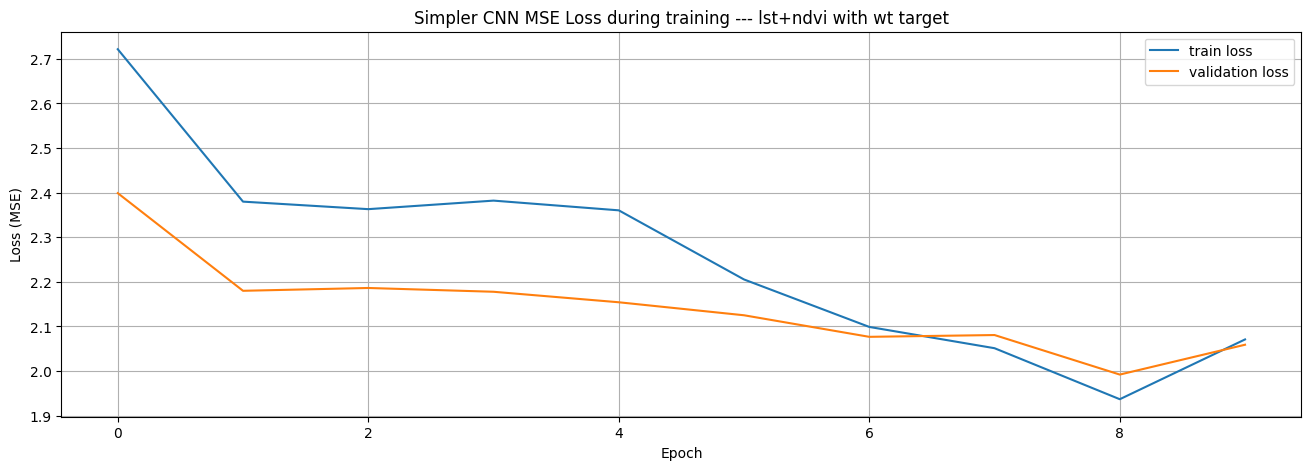

In [127]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [128]:
plt.savefig('../plots/cnn.png')

<Figure size 640x480 with 0 Axes>

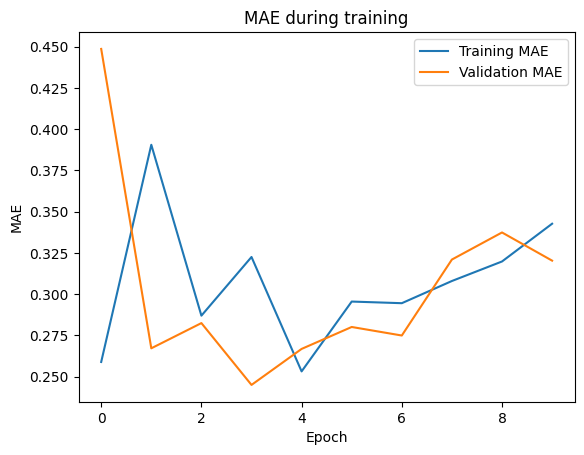

In [129]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

In [130]:
# Evaluar el modelo en el conjunto de validación
loss, mae = simplified_cnn_model.evaluate(validation_input, validation_target)

print(f'Pérdida (MSE) en validación: {loss}')
print(f'MAE en validación: {mae}')

1/1 [==============================] - 0s 35ms/step - loss: 2.0591 - mae: 0.3203
Pérdida (MSE) en validación: 2.059100866317749
MAE en validación: 0.32034000754356384


In [131]:
validation_prediction = simplified_cnn_model.predict(validation_input)
test_prediction = simplified_cnn_model.predict(test_input)

1/1 [==============================] - 0s 23ms/step


In [132]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

test_target_flat = test_target.reshape(-1)
test_prediction_flat = test_prediction.reshape(-1)

In [133]:
val_target_mask = validation_target_flat[validation_target_flat!= 0]
val_pred_mask = validation_prediction_flat[validation_target_flat!= 0]
test_target_mask = test_target_flat[test_target_flat!= 0]
test_pred_mask = test_prediction_flat[test_target_flat!= 0]

Overall results

In [134]:
results = evaluate_model(val_target_mask, val_pred_mask)
print('Validation results')
for k,v in results.items():
  print(k,':',v)

Validation results
MAE : 7.3072567
MSE : 220.09299
RMSE : 9.417875
R² : -1.4039394592831926
MAPE (%) : 114.34886455535889
MSE sample-wise : 88.69637


In [135]:
results = evaluate_model(test_target_mask, test_pred_mask)
print('Test results')
for k,v in results.items():
  print(k,':',v)

Test results
MAE : 7.454367
MSE : 44.244175
RMSE : 9.273365
R² : -1.9002914892932896
MAPE (%) : 71.07688188552856
MSE sample-wise : 85.9953


Image wise metrics results

In [136]:
c = 0
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    samples_per_image = test_target.shape[1]*test_target.shape[2]
    # Flatten the true and predicted values for this sample
    y_true_flatten = test_target_flat[c:c+samples_per_image]
    y_true_mask = y_true_flatten[y_true_flatten!= 0]

    y_pred_flatten = test_prediction_flat[c:c+samples_per_image]
    y_pred_mask = y_pred_flatten[y_true_flatten!= 0]

    #print(y_true_flatten.shape,y_pred_flatten.shape)
    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


    c += samples_per_image

for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

{'MAE': 7.366075, 'MSE': 87.09483, 'RMSE': 7.453351, 'R²': -56.712537007869216, 'MAPE (%)': 71.18945777416229, 'MSE sample-wise': 83.03875}


See what are the areas with more prediction error

In [137]:
validation_prediction[0].shape

(256, 256)

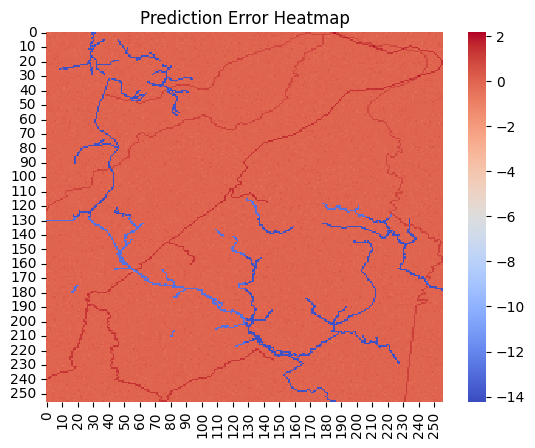

In [138]:
diff = validation_prediction[0] - validation_target[0]
sns.heatmap(diff, cmap='coolwarm')
plt.title('Prediction Error Heatmap')
plt.show()

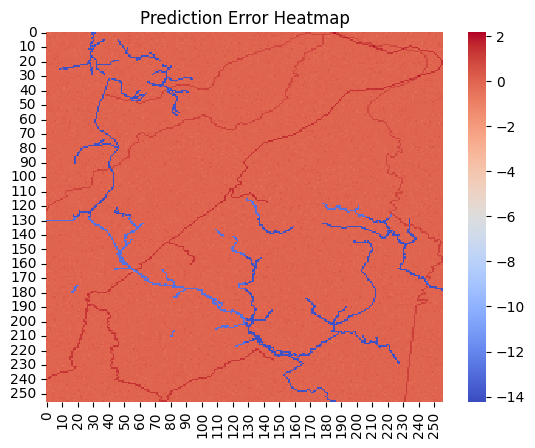

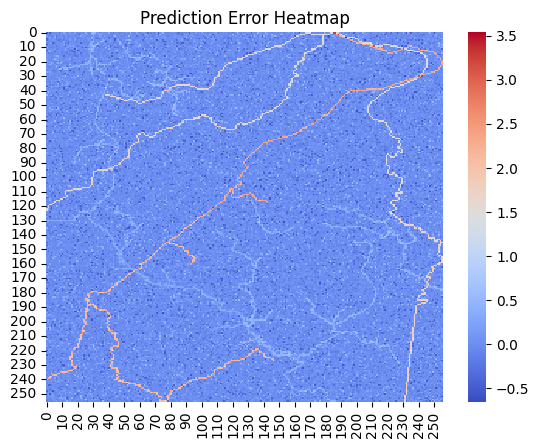

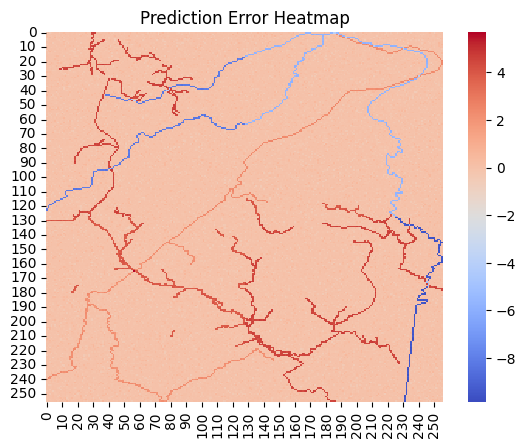

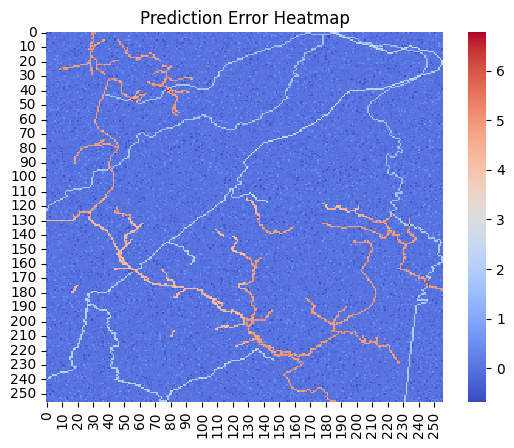

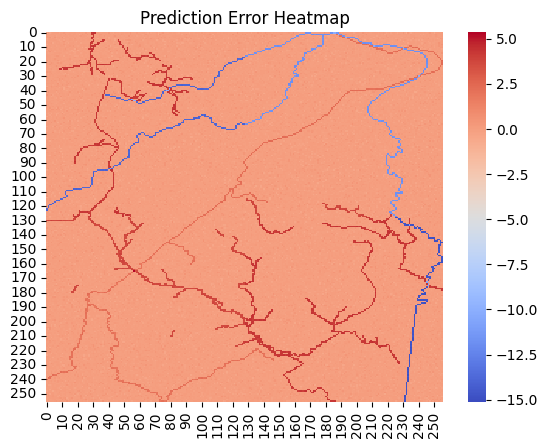

In [139]:
diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

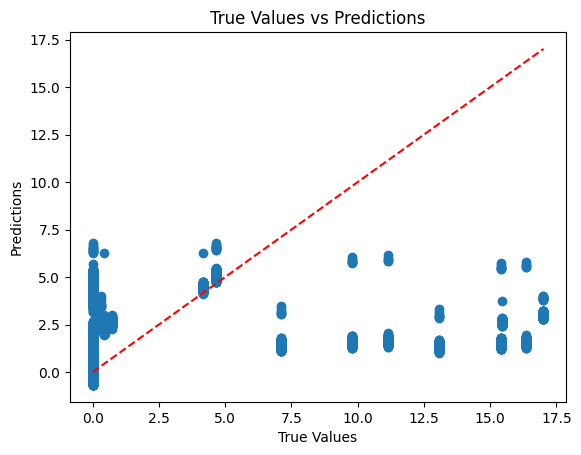

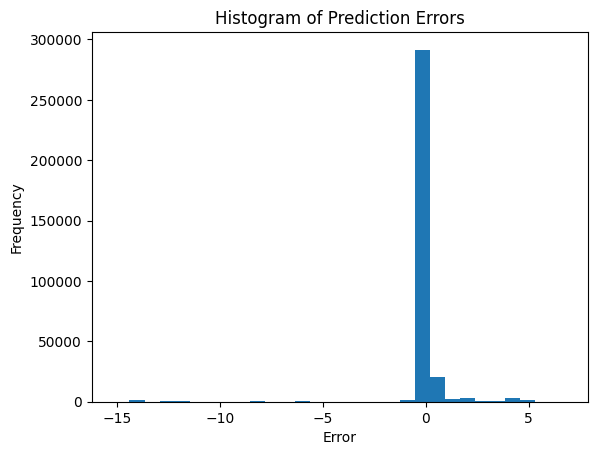

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


#### Save model results

In [141]:
model_name = "img_wise_CNN"
details = {'RMSE':mean_results['RMSE'],'Variables':inputs,'Input': 'la Broye', 'Output': 'wt', 'Resolution': W, 'nº samples': len(data_targets), 'Batch size': batch_size, 'Epochs': epochs}

file_path = f"../results/{model_name}_results.xlsx"
save_excel(file_path, details, excel = 'Results')

mean_results['Model'] = model_name
file_path = f"../results/all_results.xlsx"
save_excel(file_path, mean_results, excel = 'Results')